In [1]:
import requests
import pandas as pd

def request(url, params):
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error en la solicitud: {response.status_code}")
        return None

url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'
params = {
    'format': 'geojson',
    'starttime': '2014-10-21',
    'endtime': '2015-10-21',
    'minmagnitude': 0,
    'limit': 20000,
}

response = request(url, params)

In [2]:
if response is not None:
    earthquakes = []
    for feature in response['features']:
        properties = feature['properties']
        geometry = feature['geometry']

        earthquake_info = {
            'place': properties['place'],
            'magnitude': properties['mag'],
            'time': pd.to_datetime(properties['time'], unit='ms'),
            'latitude': geometry['coordinates'][1],
            'longitude': geometry['coordinates'][0],
            'depth': geometry['coordinates'][2],
        }
        earthquakes.append(earthquake_info)

    df = pd.DataFrame(earthquakes)

    df.to_csv('earthquakes_last_10_years.csv', index=False)
    print("Datos guardados en 'earthquakes_last_10_years.csv'.")

    df.to_excel('earthquakes_last_10_years.xlsx', index=False)
    print("Datos guardados en 'earthquakes_last_10_years.xlsx'.")

Datos guardados en 'earthquakes_last_10_years.csv'.
Datos guardados en 'earthquakes_last_10_years.xlsx'.


,Description,Value
0,Session id,123
1,Target,magnitude
2,Target type,Regression
3,Original data shape,"(16000, 10)"
4,Transformed data shape,"(16000, 35)"
5,Transformed train set shape,"(11200, 35)"
6,Transformed test set shape,"(4800, 35)"
7,Numeric features,3
8,Categorical features,6
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:56:29
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.3471,0.2296,0.4788,0.8670,0.1931,0.4345,0.9370
et,Extra Trees Regressor,0.3545,0.2402,0.4898,0.8609,0.1990,0.4452,0.7460
lightgbm,Light Gradient Boosting Machine,0.3597,0.2439,0.4936,0.8587,0.2005,0.4793,0.1320
xgboost,Extreme Gradient Boosting,0.3673,0.2532,0.5030,0.8534,0.2034,0.4658,0.0690
gbr,Gradient Boosting Regressor,0.3902,0.2805,0.5294,0.8376,0.2179,0.5594,0.2770
dt,Decision Tree Regressor,0.4764,0.4401,0.6628,0.7446,0.2655,0.5319,0.0470
ada,AdaBoost Regressor,0.6401,0.5785,0.7604,0.6650,0.3247,1.0602,0.1710
knn,K Neighbors Regressor,0.6475,0.7603,0.8718,0.5593,0.3310,0.8144,0.0500
br,Bayesian Ridge,0.7127,0.8078,0.8986,0.5322,0.3529,1.0652,0.0320
lar,Least Angle Regression,0.7126,0.8078,0.8986,0.5322,0.3530,1.0650,0.0330


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:57:06
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3530,0.2453,0.4952,0.8516,0.1964,0.3759
1,0.3385,0.2194,0.4684,0.8744,0.1891,0.3881
2,0.3426,0.2326,0.4823,0.8657,0.1915,0.3958
3,0.3396,0.2172,0.4660,0.8872,0.1924,0.4971
4,0.3326,0.2087,0.4568,0.8664,0.1895,0.4298
5,0.3451,0.2114,0.4598,0.8841,0.1870,0.5065
6,0.3670,0.2544,0.5044,0.8551,0.2008,0.5007
7,0.3609,0.2451,0.4951,0.8529,0.1981,0.3964
8,0.3552,0.2522,0.5022,0.8571,0.2006,0.4685


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3473,0.2334,0.4831,0.8697,0.1906,0.4169


       magnitude
10650       0.60
2041        2.00
8668        0.71
1114        0.00
13902       1.70
...          ...
4073        1.64
7442        1.10
9999        0.60
1870        0.72
15196       0.10

[4000 rows x 1 columns]


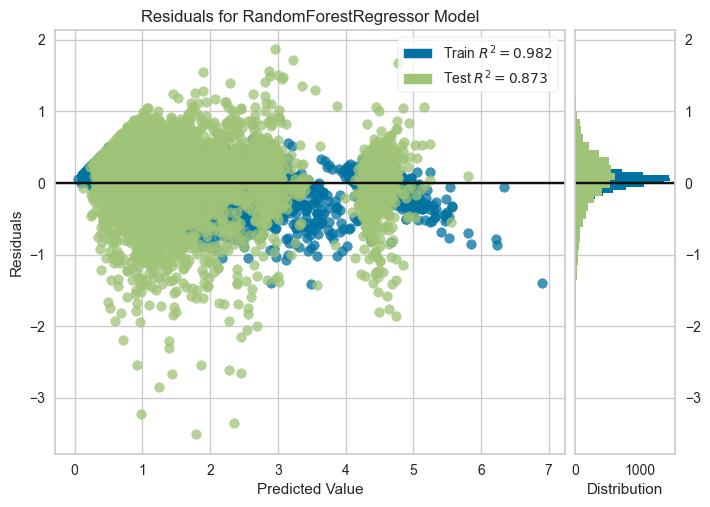

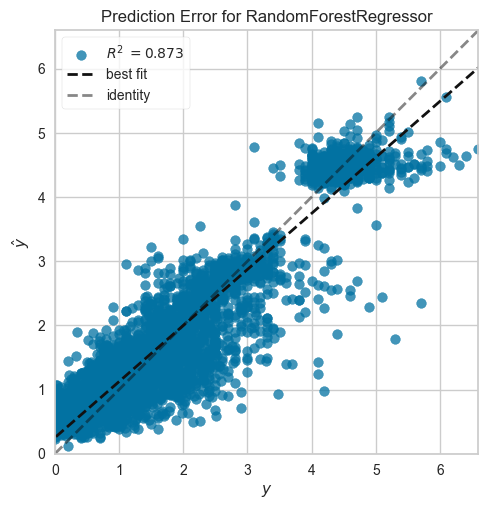

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['latitude', 'longitude', 'depth'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['year', 'month', 'day', 'hour',
                                              'minute', 'second'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('onehot_encoding',
                  TransformerWrapper(incl...
                                     transformer=OneHotEncoder(cols=['year',
                                                                     'month',
                                                                     'hour'],
                                                               handle_missing='return_nan',
                                                               use_cat_names=True))),
 

In [3]:
from pycaret.regression import *
from sklearn.model_selection import train_test_split

df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df['second'] = df['time'].dt.second

df = df.drop(columns=['place', 'time'])

X = df.drop(columns=['magnitude'])
y = df['magnitude']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)

exp_reg = setup(data=train_data, target='magnitude', session_id=123,
                normalize=True,
                categorical_features=['year', 'month', 'day', 'hour', 'minute', 'second'])

best_model = compare_models()

final_model = create_model(best_model)

test_data = pd.concat([X_test, y_test], axis=1)
predictions = predict_model(final_model, data=test_data)

print(predictions[['magnitude']])

plot_model(final_model, plot='residuals')
plot_model(final_model, plot='error')

final_tuned_model = finalize_model(final_model)
save_model(final_tuned_model, 'best_earthquake_model')